In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: 


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

In [5]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [6]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

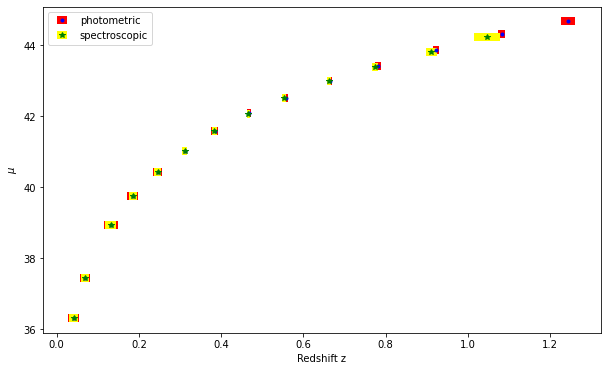

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [8]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [9]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [10]:
len(dfp)

14

In [11]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [12]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [13]:
np.shape(noise1y)

(14, 2)

In [14]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


In [15]:
np.shape(y), np.shape(z)

((42, 2), (42,))

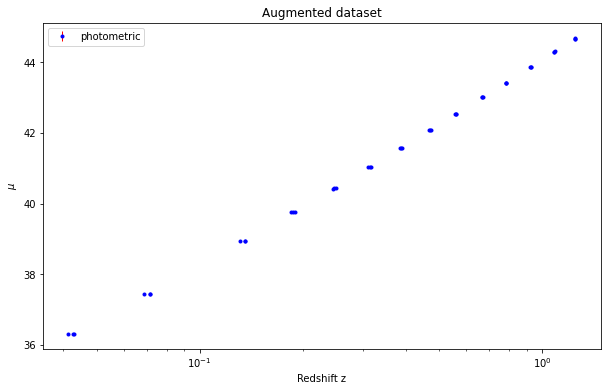

In [16]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [17]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z_sc = scalerz.transform(z.reshape(-1,1))
np.shape(z_sc)

(42, 1)

In [18]:
split = 0.9
ntrain = int(split * len(z))

randomize = np.random.permutation(len(z))
z = z_sc[randomize]
y = y[randomize]

indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(z_test), np.shape(y_train), np.shape(y_test)

((37, 1), (5, 1), (37, 2), (5, 2))

In [19]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [20]:
yy_train = np.append(y_train, np.array([y_or[0], y_or[-1]]), axis=0)
zz_train = np.append(z_train, np.array([z_sc[0], z_sc[-1]]))
np.shape(zz_train), np.shape(yy_train)

((39,), (39, 2))

In [21]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[3], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 8
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[200,200,200,200])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               400       
                                                                 
 MCDropout_1 (MCDropout)     (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_3 (MCDropout)     (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               4

In [22]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(zz_train, yy_train, batch_size=batch_size,
                                    epochs=2500, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2500
5/5 [==============================] - 1s 37ms/step - loss: 861.2402 - val_loss: 843.2215
Epoch 2/2500
5/5 [==============================] - 0s 7ms/step - loss: 859.7446 - val_loss: 842.0778
Epoch 3/2500
5/5 [==============================] - 0s 7ms/step - loss: 858.1873 - val_loss: 839.7432
Epoch 4/2500
5/5 [==============================] - 0s 7ms/step - loss: 856.6403 - val_loss: 836.8386
Epoch 5/2500
5/5 [==============================] - 0s 7ms/step - loss: 855.5583 - val_loss: 834.6843
Epoch 6/2500
5/5 [==============================] - 0s 8ms/step - loss: 853.8103 - val_loss: 832.4552
Epoch 7/2500
5/5 [==============================] - 0s 7ms/step - loss: 851.8229 - val_loss: 829.0612
Epoch 8/2500
5/5 [==============================] - 0s 7ms/step - loss: 850.0005 - val_loss: 826.0189
Epoch 9/2500
5/5 [==============================] - 0s 7ms/step - loss: 847.0596 - val_loss: 822.6459
Epoch 10/2500
5/5 [==============================] - 0s 7ms/step - loss: 844.0737

5/5 [==============================] - 0s 7ms/step - loss: 46.4129 - val_loss: 42.5667
Epoch 82/2500
5/5 [==============================] - 0s 7ms/step - loss: 40.4259 - val_loss: 32.1176
Epoch 83/2500
5/5 [==============================] - 0s 7ms/step - loss: 42.4135 - val_loss: 19.1696
Epoch 84/2500
5/5 [==============================] - 0s 7ms/step - loss: 32.4580 - val_loss: 13.8701
Epoch 85/2500
5/5 [==============================] - 0s 7ms/step - loss: 37.9536 - val_loss: 33.3299
Epoch 86/2500
5/5 [==============================] - 0s 7ms/step - loss: 39.4823 - val_loss: 32.4386
Epoch 87/2500
5/5 [==============================] - 0s 7ms/step - loss: 36.8706 - val_loss: 40.5202
Epoch 88/2500
5/5 [==============================] - 0s 8ms/step - loss: 31.6346 - val_loss: 25.7159
Epoch 89/2500
5/5 [==============================] - 0s 7ms/step - loss: 34.6498 - val_loss: 47.9038
Epoch 90/2500
5/5 [==============================] - 0s 7ms/step - loss: 38.0683 - val_loss: 20.7741
Epoc

5/5 [==============================] - 0s 7ms/step - loss: 4.8962 - val_loss: 7.5904
Epoch 163/2500
5/5 [==============================] - 0s 7ms/step - loss: 6.1464 - val_loss: 15.4814
Epoch 164/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.0969 - val_loss: 8.1408
Epoch 165/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.2501 - val_loss: 3.6010
Epoch 166/2500
5/5 [==============================] - 0s 8ms/step - loss: 5.4737 - val_loss: 16.8909
Epoch 167/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.7117 - val_loss: 7.0460
Epoch 168/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.7451 - val_loss: 8.6730
Epoch 169/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.4626 - val_loss: 8.1856
Epoch 170/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.4245 - val_loss: 7.8373
Epoch 171/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.5062 - val_loss: 1.0744
Epoch 172/250

Epoch 244/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.8211 - val_loss: 9.4358
Epoch 245/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.4166 - val_loss: 15.6080
Epoch 246/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.3518 - val_loss: 6.7808
Epoch 247/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.7612 - val_loss: 3.5650
Epoch 248/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.0779 - val_loss: 3.9852
Epoch 249/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.8560 - val_loss: 6.9340
Epoch 250/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.5823 - val_loss: 17.3385
Epoch 251/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.8907 - val_loss: 5.1906
Epoch 252/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.2998 - val_loss: 2.2121
Epoch 253/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.7839 - val_loss: 3.304

Epoch 326/2500
5/5 [==============================] - 0s 9ms/step - loss: 5.2375 - val_loss: 3.2026
Epoch 327/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.9044 - val_loss: 5.1117
Epoch 328/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.2637 - val_loss: 4.6342
Epoch 329/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.7785 - val_loss: 1.0233
Epoch 330/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7036 - val_loss: 12.8910
Epoch 331/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.4917 - val_loss: 1.8447
Epoch 332/2500
5/5 [==============================] - 0s 8ms/step - loss: 5.2776 - val_loss: 4.5383
Epoch 333/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.1525 - val_loss: 3.8003
Epoch 334/2500
5/5 [==============================] - 0s 8ms/step - loss: 7.2900 - val_loss: 4.3598
Epoch 335/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.7403 - val_loss: 2.3263

Epoch 408/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.7775 - val_loss: 3.0625
Epoch 409/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.9554 - val_loss: 5.8270
Epoch 410/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.3157 - val_loss: 11.6852
Epoch 411/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.6230 - val_loss: 4.5662
Epoch 412/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.1727 - val_loss: 5.0718
Epoch 413/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.5409 - val_loss: 5.4261
Epoch 414/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.9288 - val_loss: 7.4873
Epoch 415/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6602 - val_loss: 14.9913
Epoch 416/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.7818 - val_loss: 6.8678
Epoch 417/2500
5/5 [==============================] - 0s 9ms/step - loss: 3.7433 - val_loss: 1.171

Epoch 490/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6380 - val_loss: 5.3412
Epoch 491/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.1486 - val_loss: 0.9614
Epoch 492/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.8061 - val_loss: 5.4694
Epoch 493/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.9180 - val_loss: 3.4128
Epoch 494/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.5329 - val_loss: 4.2120
Epoch 495/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.2718 - val_loss: 5.7635
Epoch 496/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.3345 - val_loss: 5.7149
Epoch 497/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.4636 - val_loss: 6.7353
Epoch 498/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7734 - val_loss: 3.8981
Epoch 499/2500
5/5 [==============================] - 0s 7ms/step - loss: 6.4360 - val_loss: 2.4127


Epoch 572/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.9765 - val_loss: 3.1229
Epoch 573/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2880 - val_loss: 3.9325
Epoch 574/2500
5/5 [==============================] - 0s 8ms/step - loss: 5.2526 - val_loss: 1.2296
Epoch 575/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.4667 - val_loss: 2.6371
Epoch 576/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.7786 - val_loss: 5.1075
Epoch 577/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7770 - val_loss: 3.4572
Epoch 578/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5146 - val_loss: 4.0673
Epoch 579/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.5937 - val_loss: 3.4953
Epoch 580/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.3135 - val_loss: 4.6018
Epoch 581/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.8328 - val_loss: 3.3421


Epoch 654/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6459 - val_loss: 1.3864
Epoch 655/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0638 - val_loss: 2.1414
Epoch 656/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.1493 - val_loss: 2.4787
Epoch 657/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.5127 - val_loss: 2.5644
Epoch 658/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2957 - val_loss: 9.8652
Epoch 659/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.6632 - val_loss: 5.2895
Epoch 660/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.4666 - val_loss: 8.2276
Epoch 661/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.9559 - val_loss: 4.6631
Epoch 662/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.0540 - val_loss: 5.1709
Epoch 663/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0673 - val_loss: 5.4248


Epoch 736/2500
5/5 [==============================] - 0s 7ms/step - loss: 6.3449 - val_loss: 9.8124
Epoch 737/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1364 - val_loss: 4.4534
Epoch 738/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7341 - val_loss: 0.6917
Epoch 739/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.1749 - val_loss: 2.5063
Epoch 740/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.1206 - val_loss: 5.5461
Epoch 741/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.4985 - val_loss: 2.7611
Epoch 742/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.3258 - val_loss: 0.2509
Epoch 743/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9220 - val_loss: 5.5221
Epoch 744/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.2388 - val_loss: 5.1172
Epoch 745/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.7349 - val_loss: 0.4723


Epoch 818/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.8765 - val_loss: 10.6851
Epoch 819/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.1651 - val_loss: 4.3708
Epoch 820/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3679 - val_loss: 5.3043
Epoch 821/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5176 - val_loss: 3.7802
Epoch 822/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.8145 - val_loss: 2.7779
Epoch 823/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4992 - val_loss: 0.1850
Epoch 824/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4278 - val_loss: 6.0951
Epoch 825/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.8679 - val_loss: 3.0706
Epoch 826/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.7510 - val_loss: 3.3711
Epoch 827/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.5728 - val_loss: 10.371

Epoch 900/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.8633 - val_loss: 1.5583
Epoch 901/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.8278 - val_loss: 2.6758
Epoch 902/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.1833 - val_loss: 1.8483
Epoch 903/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.6015 - val_loss: 4.1732
Epoch 904/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.2506 - val_loss: 5.4493
Epoch 905/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.3928 - val_loss: 2.9834
Epoch 906/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.6908 - val_loss: 3.1920
Epoch 907/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0265 - val_loss: 4.2665
Epoch 908/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.5934 - val_loss: 1.1559
Epoch 909/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.4960 - val_loss: 2.4946


Epoch 982/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3424 - val_loss: 1.1291
Epoch 983/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.0648 - val_loss: 2.2022
Epoch 984/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2175 - val_loss: 1.0096
Epoch 985/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.1196 - val_loss: 6.1233
Epoch 986/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8630 - val_loss: 3.4874
Epoch 987/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3269 - val_loss: 1.8392
Epoch 988/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.5295 - val_loss: 3.2774
Epoch 989/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3011 - val_loss: 5.2635
Epoch 990/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.4583 - val_loss: 3.8112
Epoch 991/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.9739 - val_loss: 5.2346


5/5 [==============================] - 0s 8ms/step - loss: 2.7976 - val_loss: 9.1456
Epoch 1064/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.7088 - val_loss: 2.4460
Epoch 1065/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.9052 - val_loss: 4.5129
Epoch 1066/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.2136 - val_loss: 1.7549
Epoch 1067/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6204 - val_loss: 3.0557
Epoch 1068/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.0203 - val_loss: 6.5856
Epoch 1069/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.5456 - val_loss: 1.2529
Epoch 1070/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7721 - val_loss: 3.9304
Epoch 1071/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4638 - val_loss: 2.8151
Epoch 1072/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.4207 - val_loss: 0.8836
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 3.0891 - val_loss: 2.9001
Epoch 1145/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5450 - val_loss: 1.5423
Epoch 1146/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0591 - val_loss: 4.1066
Epoch 1147/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4795 - val_loss: 7.0237
Epoch 1148/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.5423 - val_loss: 4.6608
Epoch 1149/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9197 - val_loss: 3.3938
Epoch 1150/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8514 - val_loss: 2.5991
Epoch 1151/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0851 - val_loss: 4.8744
Epoch 1152/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.8262 - val_loss: 2.2023
Epoch 1153/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2221 - val_loss: 3.4995
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 2.2123 - val_loss: 6.3861
Epoch 1226/2500
5/5 [==============================] - 0s 10ms/step - loss: 3.8524 - val_loss: 2.2247
Epoch 1227/2500
5/5 [==============================] - 0s 11ms/step - loss: 3.1282 - val_loss: 0.8357
Epoch 1228/2500
5/5 [==============================] - 0s 9ms/step - loss: 2.7295 - val_loss: 5.3948
Epoch 1229/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.8524 - val_loss: 5.3133
Epoch 1230/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.4001 - val_loss: 3.6092
Epoch 1231/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.6619 - val_loss: 3.2137
Epoch 1232/2500
5/5 [==============================] - 0s 9ms/step - loss: 3.3521 - val_loss: 1.8897
Epoch 1233/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5095 - val_loss: 1.1589
Epoch 1234/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6209 - val_loss: 1.8633
Epoc

5/5 [==============================] - 0s 7ms/step - loss: 4.0148 - val_loss: 0.8036
Epoch 1307/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.0224 - val_loss: 3.1793
Epoch 1308/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.6488 - val_loss: 2.4168
Epoch 1309/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6207 - val_loss: 9.2632
Epoch 1310/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.9458 - val_loss: 0.7064
Epoch 1311/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.2509 - val_loss: 5.1731
Epoch 1312/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2389 - val_loss: 4.1064
Epoch 1313/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7685 - val_loss: 1.3233
Epoch 1314/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.1583 - val_loss: 3.4870
Epoch 1315/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.6542 - val_loss: 2.7470
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 3.4348 - val_loss: 3.0788
Epoch 1388/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5392 - val_loss: 7.3886
Epoch 1389/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.0838 - val_loss: 2.2563
Epoch 1390/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9110 - val_loss: 4.7899
Epoch 1391/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.4307 - val_loss: 3.9841
Epoch 1392/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9231 - val_loss: 7.8301
Epoch 1393/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.5815 - val_loss: 1.4061
Epoch 1394/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.2769 - val_loss: 3.5968
Epoch 1395/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9468 - val_loss: 3.5273
Epoch 1396/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.2428 - val_loss: 4.4631
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 2.3437 - val_loss: 4.2447
Epoch 1469/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3691 - val_loss: 0.7501
Epoch 1470/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3657 - val_loss: 0.9226
Epoch 1471/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.1639 - val_loss: 0.8595
Epoch 1472/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7985 - val_loss: 1.5501
Epoch 1473/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4682 - val_loss: 3.1314
Epoch 1474/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9889 - val_loss: 0.4024
Epoch 1475/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0702 - val_loss: 2.3748
Epoch 1476/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.8763 - val_loss: 6.1810
Epoch 1477/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0844 - val_loss: 2.5978
Epoch 

5/5 [==============================] - 0s 8ms/step - loss: 2.2392 - val_loss: 5.7565
Epoch 1550/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8501 - val_loss: 1.8155
Epoch 1551/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4505 - val_loss: 2.2480
Epoch 1552/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.5022 - val_loss: 0.9757
Epoch 1553/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.7856 - val_loss: 1.0637
Epoch 1554/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8432 - val_loss: 3.0641
Epoch 1555/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.2505 - val_loss: 3.9952
Epoch 1556/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0033 - val_loss: 1.3895
Epoch 1557/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.9725 - val_loss: 1.7518
Epoch 1558/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.1120 - val_loss: 1.3801
Epoch 

5/5 [==============================] - 0s 8ms/step - loss: 2.2053 - val_loss: 3.7456
Epoch 1631/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.9302 - val_loss: 2.6381
Epoch 1632/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0950 - val_loss: 2.6162
Epoch 1633/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.7761 - val_loss: 2.4906
Epoch 1634/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8696 - val_loss: 1.6168
Epoch 1635/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.5021 - val_loss: 3.5164
Epoch 1636/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.4061 - val_loss: 1.8768
Epoch 1637/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9216 - val_loss: 0.9434
Epoch 1638/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3023 - val_loss: 4.2609
Epoch 1639/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3931 - val_loss: 4.9383
Epoch 

5/5 [==============================] - 0s 8ms/step - loss: 2.7350 - val_loss: 0.7265
Epoch 1712/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.6897 - val_loss: 1.2628
Epoch 1713/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0791 - val_loss: 3.5204
Epoch 1714/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8721 - val_loss: 0.7156
Epoch 1715/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1992 - val_loss: 1.7238
Epoch 1716/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.4703 - val_loss: 1.8427
Epoch 1717/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.3477 - val_loss: 3.7063
Epoch 1718/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1261 - val_loss: 5.1162
Epoch 1719/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6619 - val_loss: 2.3395
Epoch 1720/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.6348 - val_loss: 0.2717
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 2.8999 - val_loss: 4.7183
Epoch 1793/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4869 - val_loss: 6.6151
Epoch 1794/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3649 - val_loss: 5.8979
Epoch 1795/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8731 - val_loss: 1.4505
Epoch 1796/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9508 - val_loss: 5.4626
Epoch 1797/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.3777 - val_loss: 1.2026
Epoch 1798/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.2796 - val_loss: 6.4753
Epoch 1799/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.4937 - val_loss: 0.7231
Epoch 1800/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.6816 - val_loss: 2.2722
Epoch 1801/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2092 - val_loss: 1.1222
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 2.2364 - val_loss: 2.0573
Epoch 1874/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.8089 - val_loss: 1.8296
Epoch 1875/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.9806 - val_loss: 6.5468
Epoch 1876/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8292 - val_loss: 4.6421
Epoch 1877/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.2291 - val_loss: 3.7373
Epoch 1878/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.3443 - val_loss: 3.9129
Epoch 1879/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4249 - val_loss: 5.4281
Epoch 1880/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0144 - val_loss: 2.6752
Epoch 1881/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.6557 - val_loss: 1.4947
Epoch 1882/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9101 - val_loss: 5.0564
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 3.3431 - val_loss: 2.6259
Epoch 1955/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.7668 - val_loss: 1.7295
Epoch 1956/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8850 - val_loss: 1.6786
Epoch 1957/2500
5/5 [==============================] - 0s 8ms/step - loss: 1.9786 - val_loss: 2.9888
Epoch 1958/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.6197 - val_loss: 2.8322
Epoch 1959/2500
5/5 [==============================] - 0s 9ms/step - loss: 2.3287 - val_loss: 1.7343
Epoch 1960/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1633 - val_loss: 1.2930
Epoch 1961/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.8514 - val_loss: 2.6526
Epoch 1962/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.8542 - val_loss: 1.8293
Epoch 1963/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.7860 - val_loss: 1.5901
Epoch 

5/5 [==============================] - 0s 8ms/step - loss: 3.8283 - val_loss: 3.1459
Epoch 2036/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9592 - val_loss: 1.1700
Epoch 2037/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.1378 - val_loss: 4.6377
Epoch 2038/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4924 - val_loss: 3.7098
Epoch 2039/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.6434 - val_loss: 4.2815
Epoch 2040/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1803 - val_loss: 2.9374
Epoch 2041/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.6617 - val_loss: 1.8448
Epoch 2042/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8283 - val_loss: 1.8326
Epoch 2043/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1162 - val_loss: 5.1121
Epoch 2044/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1340 - val_loss: 3.1434
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 2.7165 - val_loss: 2.1539
Epoch 2117/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.9572 - val_loss: 3.2188
Epoch 2118/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.5945 - val_loss: 2.8156
Epoch 2119/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.2219 - val_loss: 3.2878
Epoch 2120/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3538 - val_loss: 5.7463
Epoch 2121/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.6732 - val_loss: 4.7485
Epoch 2122/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.9734 - val_loss: 2.8394
Epoch 2123/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.8896 - val_loss: 1.1323
Epoch 2124/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.4088 - val_loss: 4.4471
Epoch 2125/2500
5/5 [==============================] - 0s 8ms/step - loss: 1.8643 - val_loss: 2.3875
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 2.5521 - val_loss: 0.8953
Epoch 2198/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2663 - val_loss: 1.7727
Epoch 2199/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.8078 - val_loss: 0.6433
Epoch 2200/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5924 - val_loss: 0.6072
Epoch 2201/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1759 - val_loss: 6.3897
Epoch 2202/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3412 - val_loss: 0.3917
Epoch 2203/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5345 - val_loss: 3.7859
Epoch 2204/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.9268 - val_loss: 4.3044
Epoch 2205/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.7714 - val_loss: 1.2494
Epoch 2206/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.7681 - val_loss: 6.1226
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 1.9554 - val_loss: 5.1001
Epoch 2279/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1633 - val_loss: 1.8628
Epoch 2280/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5616 - val_loss: 2.0718
Epoch 2281/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.9069 - val_loss: 2.3474
Epoch 2282/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.7229 - val_loss: 0.8617
Epoch 2283/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8103 - val_loss: 2.4466
Epoch 2284/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.5010 - val_loss: 3.4076
Epoch 2285/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3685 - val_loss: 0.9617
Epoch 2286/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.2819 - val_loss: 3.3621
Epoch 2287/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.7413 - val_loss: 1.7671
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 1.4662 - val_loss: 2.0893
Epoch 2360/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.8251 - val_loss: 1.3477
Epoch 2361/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3696 - val_loss: 1.1833
Epoch 2362/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9453 - val_loss: 2.7264
Epoch 2363/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3449 - val_loss: 1.9043
Epoch 2364/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0582 - val_loss: 2.9469
Epoch 2365/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.1217 - val_loss: 3.7423
Epoch 2366/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.9740 - val_loss: 1.3046
Epoch 2367/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.9143 - val_loss: 1.0854
Epoch 2368/2500
5/5 [==============================] - 0s 8ms/step - loss: 3.0013 - val_loss: 2.6358
Epoch 

5/5 [==============================] - 0s 8ms/step - loss: 2.0750 - val_loss: 3.2427
Epoch 2441/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.8984 - val_loss: 2.0326
Epoch 2442/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4642 - val_loss: 0.7860
Epoch 2443/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.2667 - val_loss: 1.3446
Epoch 2444/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.2158 - val_loss: 3.3271
Epoch 2445/2500
5/5 [==============================] - 0s 8ms/step - loss: 1.3939 - val_loss: 0.7225
Epoch 2446/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.8295 - val_loss: 0.9910
Epoch 2447/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.4424 - val_loss: 4.1166
Epoch 2448/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3144 - val_loss: 3.6685
Epoch 2449/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3627 - val_loss: 0.1910
Epoch 

In [23]:
model_train.history['val_loss'][-1]

2.4589946269989014

In [24]:
model.save('models/short_lsst_data_model.h5')

(0.0, 200.0)

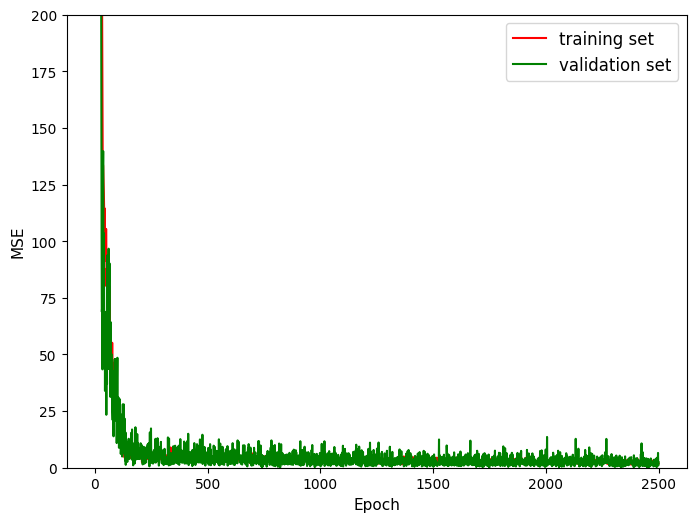

In [25]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [26]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 200 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


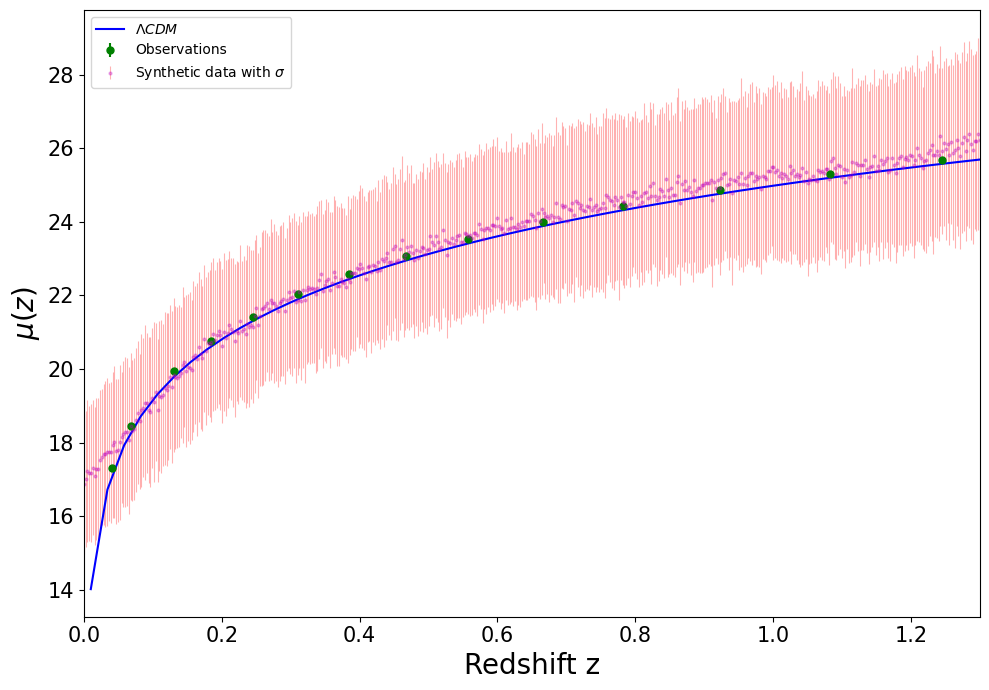

In [27]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig('firs_model.png', dpi=100)
# zCMB 	MU 	errors